### Import Python Libraries

In [48]:
import pandas as pd
import yaml
import requests
import networkx as nx

### Configure Global Settings

In [32]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pio.renderers.default = "browser"

### Download OSSEM Data Set

In [33]:
# Download OSSEM DATA
url_ossem = 'https://raw.githubusercontent.com/OTRF/OSSEM-DM/main/use-cases/mitre_attack/techniques_to_events_mapping.yaml'
yaml_content = requests.get(url_ossem)
yaml_mapping = yaml.safe_load(yaml_content.text)
df = pd.json_normalize(yaml_mapping)

In [34]:
df.head()

,technique_id,is_subtechnique,technique,tactic,platform,data_source,data_component,relationship_id,name,source,relationship,target,event_id,event_name,event_platform,audit_category,audit_sub_category,log_channel,log_provider,filter_in,filter_in.ObjectType
0,T1562.010,True,Downgrade Attack,[defense-evasion],"[Windows, Linux, macOS]",process,process creation,REL-2022-0146,User created Process,user,created,process,4688,A new process has been created.,Windows,Detailed Tracking,Process Creation,Security,Microsoft-Windows-Security-Auditing,NaN,NaN
1,T1562.010,True,Downgrade Attack,[defense-evasion],"[Windows, Linux, macOS]",process,process creation,REL-2022-0146,User created Process,user,created,process,1,Process Creation.,Windows,ProcessCreate,NaN,Microsoft-Windows-Sysmon/Operational,Microsoft-Windows-Sysmon,NaN,NaN
2,T1562.010,True,Downgrade Attack,[defense-evasion],"[Windows, Linux, macOS]",process,process creation,REL-2022-0146,User created Process,user,created,process,1,Process Creation.,Windows,ProcessCreate,NaN,Linux-Sysmon/Operational,Linux-Sysmon,NaN,NaN
3,T1562.010,True,Downgrade Attack,[defense-evasion],"[Windows, Linux, macOS]",process,process creation,REL-2022-0146,User created Process,user,created,process,ProcessCreated,ProcessCreated,Windows,None,NaN,DeviceProcessEvents,Microsoft Defender for Endpoint,NaN,NaN
4,T1562.010,True,Downgrade Attack,[defense-evasion],"[Windows, Linux, macOS]",process,process creation,REL-2022-0153,Process created Thread,process,created,thread,8,CreateRemoteThread.,Windows,CreateRemoteThread,NaN,Microsoft-Windows-Sysmon/Operational,Microsoft-Windows-Sysmon,NaN,NaN


### Organize OSSEM Data for Bar Charts

In [35]:
df_ds_dc_list = df[df['is_subtechnique'] == True][['technique_id','data_source','data_component']].drop_duplicates() # get list of unique data sources and data components
df_ds_count = df_ds_dc_list['data_source'].value_counts().to_frame().reset_index() # generate a list of unique data sources
df_ds_count.rename(columns={"index": "data_source", "data_source": "count"},inplace=True) # clean up data source column names
df_dc_count = df_ds_dc_list['data_component'].value_counts().to_frame().reset_index() # generate a list of unique data components
df_dc_count.rename(columns={"index": "data_component", "data_component": "count"},inplace=True) # clean up data component column names

### MITRE Data Sources Mapped to Techniques (Bar Chart)

In [36]:
fig = px.bar(df_ds_count, x='data_source', y='count', title="MITRE ATT&CK: Count of Techniques by Data Source",
             labels={
                     "data_source": "Data Source",
                     "count": "Techniques",
                 })
fig.show()

### MITRE Data Components Mapped to Techniques (Bar Chart)

In [37]:
fig = px.bar(df_dc_count, x='data_component', y='count', title="MITRE ATT&CK: Count of Techniques by Data Component",
             labels={
                     "data_source": "Data Component",
                     "count": "Techniques",
                 })
fig.show()

### Get List of Event IDs by Log Provider (Windows & Linux Only)

In [38]:
windows_events = df[((df["is_subtechnique"]== True) & (df["event_platform"] == 'Windows') & (df['log_provider'] != 'Microsoft Defender for Endpoint') & (df['log_provider'] != 'Linux-Sysmon') )]
linux_events = df[((df["is_subtechnique"]== True) & (df["event_platform"] == 'Linux'))]

In [39]:
windows_events.head(2)

,technique_id,is_subtechnique,technique,tactic,platform,data_source,data_component,relationship_id,name,source,relationship,target,event_id,event_name,event_platform,audit_category,audit_sub_category,log_channel,log_provider,filter_in,filter_in.ObjectType
0,T1562.010,True,Downgrade Attack,[defense-evasion],"[Windows, Linux, macOS]",process,process creation,REL-2022-0146,User created Process,user,created,process,4688,A new process has been created.,Windows,Detailed Tracking,Process Creation,Security,Microsoft-Windows-Security-Auditing,NaN,NaN
1,T1562.010,True,Downgrade Attack,[defense-evasion],"[Windows, Linux, macOS]",process,process creation,REL-2022-0146,User created Process,user,created,process,1,Process Creation.,Windows,ProcessCreate,NaN,Microsoft-Windows-Sysmon/Operational,Microsoft-Windows-Sysmon,NaN,NaN


In [40]:
linux_events.head(2)

,technique_id,is_subtechnique,technique,tactic,platform,data_source,data_component,relationship_id,name,source,relationship,target,event_id,event_name,event_platform,audit_category,audit_sub_category,log_channel,log_provider,filter_in,filter_in.ObjectType
8,T1562.010,True,Downgrade Attack,[defense-evasion],"[Windows, Linux, macOS]",process,process creation,REL-2022-0175,Process created Process,process,created,process,1,Process Creation.,Linux,ProcessCreate,NaN,Linux-Sysmon/Operational,Linux-Sysmon,NaN,NaN
16,T1562.010,True,Downgrade Attack,[defense-evasion],"[Windows, Linux, macOS]",command,command execution,REL-2022-0131,Process executed Command,process,executed,command,1,Process Creation.,Linux,ProcessCreate,NaN,Linux-Sysmon/Operational,Linux-Sysmon,NaN,NaN


### Group Windows Event IDs by Log Provider/Channel

In [41]:
windows_events.groupby(['log_provider','log_channel','event_id','event_name']).sum().head(20)

is_subtechnique
log_provider                        log_channel                              event_id event_name                                                         
Eventlog                            Security                                 1100     The event logging service has shut down.                         10
                                                                             1101     Audit events have been dropped by the transport.                 10
                                                                             1102     The audit log was cleared.                                       10
                                                                             1104     The security Log is now full.                                    10
                                    System                                   6005     The Event log service was started.                               16
                                                                             6006     The Event log service was stopped.                               16
Microsoft-Windows-PowerShell        Microsoft-Windows-PowerShell/Operational 4103     Module logging.                                                 262
                                                                             4104     Script Block Logging.                                            12
Microsoft-Windows-Security-Auditing Security                                 4610     An authentication package has been loaded by th...                4
                                                                             4611     A trusted logon process has been registered wit...                8
                                                                             4614     A notification package has been loaded by the S...                4
                                                                             4616     The system time was changed.                                     10
                                                                             4622     A security package has been loaded by the Local...                4
                                                                             4624     An account was successfully logged on.                           65
                                                                             4625     An account failed to log on.                                     20
                                                                             4648     A logon was attempted using explicit credentials.                20
                                                                             4656     A handle to an object was requested.                             56
                                                                             4657     A registry value was modified.                                  100
                                                                             4660     An object was deleted.                                           10
                                                                             4661     A handle to an object was requested.                             20

### Group Linux Event IDs by Log Provider/Channel

In [42]:
linux_events.groupby(['log_provider','log_channel','event_id','event_name']).sum()

is_subtechnique
log_provider log_channel              event_id event_name                            
Linux-Sysmon Linux-Sysmon/Operational 1        Process Creation.                  112
                                      3        Network connection.                180
                                      5        Process terminated.                  1
                                      11       FileCreate.                         50
                                      23       File Delete archived.               10

### Get Data Sources Based on List of Techniques

In [43]:
list_of_techniques = ['T1562.010', 'T1620', 'T1218.014', 'T1614.001', 'T1218.013']

In [44]:
df[df['technique_id'].isin(list_of_techniques)].groupby(['technique_id','event_platform','log_provider', 'event_id','event_name','log_channel']).sum().head(20)

is_subtechnique
technique_id event_platform log_provider                        event_id                  event_name                               log_channel                                              
T1218.013    Windows        Linux-Sysmon                        1                         Process Creation.                        Linux-Sysmon/Operational                                1
                            Microsoft Defender for Endpoint     CreateRemoteThreadApiCall CreateRemoteThreadApiCall                DeviceEvents                                            1
                                                                ProcessCreated            ProcessCreated                           DeviceProcessEvents                                     4
                            Microsoft-Windows-PowerShell        4103                      Module logging.                          Microsoft-Windows-PowerShell/Operational                2
                            Microsoft-Windows-Security-Auditing 4688                      A new process has been created.          Security                                                4
                            Microsoft-Windows-Sysmon            1                         Process Creation.                        Microsoft-Windows-Sysmon/Operational                    4
                                                                8                         CreateRemoteThread.                      Microsoft-Windows-Sysmon/Operational                    1
T1218.014    Windows        Linux-Sysmon                        1                         Process Creation.                        Linux-Sysmon/Operational                                1
                            Microsoft Defender for Endpoint     CreateRemoteThreadApiCall CreateRemoteThreadApiCall                DeviceEvents                                            1
                                                                FileCreated               FileCreated                              DeviceFileEvents                                        2
                                                                ProcessCreated            ProcessCreated                           DeviceProcessEvents                                     4
                            Microsoft-Windows-PowerShell        4103                      Module logging.                          Microsoft-Windows-PowerShell/Operational                2
                            Microsoft-Windows-Security-Auditing 4663                      An attempt was made to access an object. Security                                                2
                                                                4688                      A new process has been created.          Security                                                4
                            Microsoft-Windows-Sysmon            1                         Process Creation.                        Microsoft-Windows-Sysmon/Operational                    4
                                                                8                         CreateRemoteThread.                      Microsoft-Windows-Sysmon/Operational                    1
                                                                11                        FileCreate.                              Microsoft-Windows-Sysmon/Operational                    1
T1562.010    Linux          Linux-Sysmon                        1                         Process Creation.                        Linux-Sysmon/Operational                                2
             Windows        Linux-Sysmon                        1                         Process Creation.                        Linux-Sysmon/Operational                                1
                            Microsoft Defender for Endpoint     CreateRemoteThreadApiCall CreateRemoteThreadApiCall                DeviceEvents                                            1

### Visualizing Relationships using OpenHunt Library

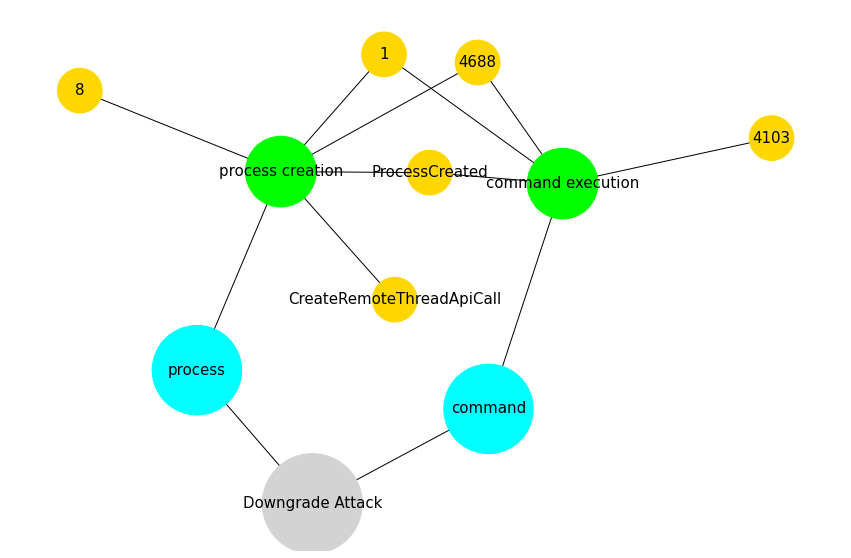

In [47]:
from openhunt import visualizations as vis
df_network_graph = df[(df['technique_id']=='T1562.010')]
vis.attack_network_graph(df_network_graph)

### References

https://attack.mitre.org/

https://github.com/OTRF/openhunt

https://github.com/OTRF/OSSEM

